## Sequential perturbations

02/16/2025

Alan M H Beem

In [1]:
N = 120
# K = 2
from package.abn_mir_helper_functions import *
from package.abn_mir_plotting_functions import select_network
from package.bn_graph_methods import *
from package.plotting import get_colors, binary_states
from random import SystemRandom as rand

### Conceptual background, introduction:

#### Perturbed Boolean networks:

Let Boolean network functions, input assignments be immutable; Each sequence of unit perturbations is fired probabilistically (a la Petri-net);

Consider a Gene Regulatory Network whose edges are derived from correlations of differentially expressed genes, from measurements of abundances of protein, RNA over a panel of perturbations or natural variation.

How different would such GRNs really be for unperturbed, and perturbed networks? In terms of design-space of perturbations / interventions, the result of weighing edges is likely not sufficiently unique to specify a cassette, further, it would not (TBD) pose a subset of subproblems (???)

As part of backtracking, a condition could be applied to the as-would-be-inferred GRN, such that ??? maybe we can expect that healthy cellular systems, with such an altered GRN, woudl still behave healthily.

#### Problem specification:

Find a sequence of unit perturbations (p1, p2) such that for all cycles (except goal cycle) there exists an interval L such that a run-in from the perturbed state (i.e. p1 has been applied, L steps have occurred, and p2 has been applied) would terminate in cycle detection of the goal cycle.

#### Assumptions:

Perturbation does not fire in goal states. (This can be relaxed, but I'm not sure it would work, practically, this could be embodied by a constitutive or conditional payload in the perturbation that fires only in the goal state, causing cell death)

#### Implication:

If such a sequential perturbation exists, then, where it is applied probabilistically to a distribution of network states, eventually, all trajectories will be in goal states.

---
Applications of a similar search, for scaled and meaningfully assigned Boolean networks, includes designed changes to cancer ecosystems.

### Set up a network for which to select sequential perturbations effecting goal states

In [2]:
# setup
net = select_network(
    num_nodes=N,
    minimum_max_cycle_length=15,
    maximum_max_cycle_length=20,
    minimum_number_of_cycles=10,
    maximum_number_of_cycles=30,
    maximum_number_of_networks=1024,
    iterations_limit=400,
)[
    0
]  # select net also returns all generated nets, used in bool_main for appendix figures
net.add_cycles(1000)
print(net)
net.compute_unit_perturbations_matrix(sort_selection=1, compute_over_t_u=False)
setup_colors = get_colors(len(net.bn_collapsed_cycles), True) + [[0.3, 0.3, 0.3, 0.5]]

BooleanNetwork: N=120. avg_k= 1.65. Run-ins: 1202. Observed cycles: 19. t_records: 1202. u_records: 0
Cycle lengths: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 12, 10, 10, 10, 4, 12, 12, 12]


#### Cycle states as binary numbers, goal cycle states as binary values
Each state is taken to be a binary integer (ex: for N=2, a state 01<sub>2</sub> -> 1, a state 11<sub>2</sub> -> 3)

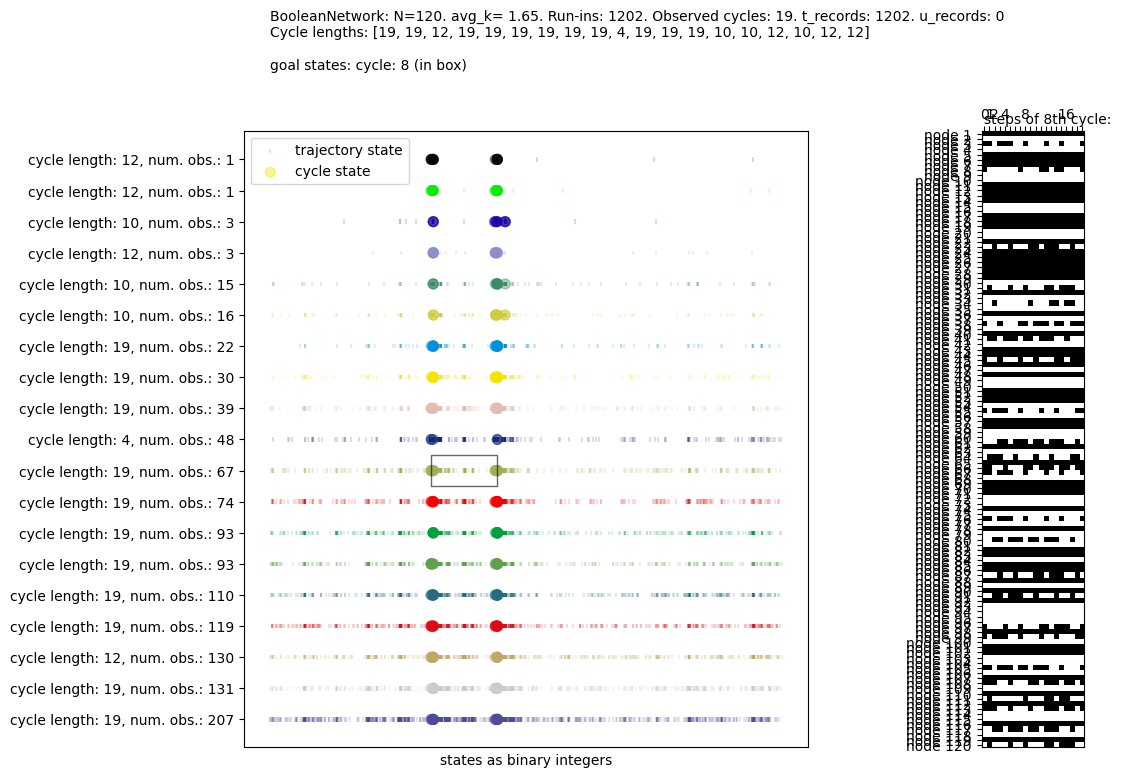

In [3]:
# goal states as a given cycle
goal_cycle_index = rand().randrange(0, len(net.bn_collapsed_cycles.cycle_records))
fig = binary_states(net, setup_colors, goal_cycle_index, plt)
plt.show()

#### Solution method:

For each node, form a matrix A<sub>p<sub>i</sub></sub>

For all pairs of matrices A<sub>p<sub>i</sub></sub>, A<sub>p<sub>j</sub></sub>:

Does A<sub>p<sub>i</sub></sub> $*$ A<sub>p<sub>j</sub></sub> have all non-zero entries in the column of goal cycle index, for all rows except the row of goal cycle index?

If so, there does exist such a sequence of perturbations, and an interval L, 0 ≤ L ≤ longest cycle length - 1, such that applying p1, waiting L steps, and applying p2 will result in a goal state.

In [4]:
matrices = [
    np.zeros_like(net.cycles_unit_perturbations_transition_matrix) for _ in net.nodes
]
all_matrix = np.zeros_like(net.cycles_unit_perturbations_transition_matrix)
for record in net.cycles_unit_perturbations_records:
    if record.end_index is not None:
        matrices[record.perturbed_node_index][record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency
        all_matrix[record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency  # this one is for a secondary question
max_good_rows = 0
found_sequences_2 = []
# working_sequences_2 = []
best_sequence = None
for i in range(len(matrices)):
    for j in range(len(matrices)):
        matrix_product = matrices[i] @ matrices[j]
        good_rows = 0
        # print()
        # print(f"i: {i}")
        # print(f"j: {j}")
        for row in matrix_product:
            # print(f"row: {row}")
            # print(f"goal_cycle_index: {goal_cycle_index}")
            # print(f"row[goal_cycle_index]: {row[goal_cycle_index]}")
            # print()
            if row[goal_cycle_index] > 0:
                good_rows += 1
        if good_rows == len(net.bn_collapsed_cycles) - 1:
            # print(f"sequence found: {i}, {j}")
            found_sequences_2.append((i, j))
        if good_rows > max_good_rows:
            max_good_rows = good_rows
            best_sequence = (i, j)
# print(f"results:\nsequence: {found_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}")
# matrices[found_sequence[0]]@matrices[found_sequence[1]]
print(
    f"{len(found_sequences_2)} sequences of perturbations unanimously effect goal state"
)

print(
    f"results:\nsequence: {best_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}"
)

0 sequences of perturbations unanimously effect goal state
results:
sequence: (4, 15)
number of cycles for which sequence -> goal: 16


#### What about with another perturbation?

In [5]:
matrices = [
    np.zeros_like(net.cycles_unit_perturbations_transition_matrix) for _ in net.nodes
]
all_matrix = np.zeros_like(net.cycles_unit_perturbations_transition_matrix)
# all_matrix = np.eye(like=net.cycles_unit_perturbations_transition_matrix)
for record in net.cycles_unit_perturbations_records:
    if record.end_index is not None:
        matrices[record.perturbed_node_index][record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency
        all_matrix[record.start_index][
            record.end_index
        ] = 1  # 1 represents adjacency  # this one is for a secondary question
max_good_rows = 0
# found_sequence = None
found_sequences_3 = []
best_sequence_3 = None
for i in range(len(matrices)):
    for j in range(len(matrices)):
        for k in range(len(matrices)):
            matrix_product = matrices[i] @ matrices[j] @ matrices[k]
            good_rows = 0
            # print()
            # print(f"i: {i}")
            # print(f"j: {j}")
            # print(f"k: {k}")
            for row in matrix_product:
                # print(f"row: {row}")
                # print(f"goal_cycle_index: {goal_cycle_index}")
                # print(f"row[goal_cycle_index]: {row[goal_cycle_index]}")
                # print()
                if row[goal_cycle_index] > 0:
                    good_rows += 1
            if good_rows == len(net.bn_collapsed_cycles) - 1:
                # print(f"sequence found: {i}, {j}, {k}")
                found_sequences_3.append((i, j, k))
            if good_rows > max_good_rows:
                max_good_rows = good_rows
                found_sequence = (i, j, k)
# print(f"results:\nsequence: {found_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}")
# matrices[found_sequence[0]]@matrices[found_sequence[1]]
print(f"{len(found_sequences_3)} sequences of perturbations effect goal state")

print(
    f"results:\nsequence: {found_sequence}\nnumber of cycles for which sequence -> goal: {max_good_rows}"
)

1168 sequences of perturbations effect goal state
results:
sequence: (1, 1, 1)
number of cycles for which sequence -> goal: 19


#### Initially, no, at least with the network I was looking at, there is not such a sequence of perturbations. But what about with more perturbations?

But, taking up to all transitions, is the graph of cycles strongly connected?

Below is examined whether a permutation of the order of perturbations (matrix multiplications) results in reachability for all cycles, or, restricts reachability to the goal column.

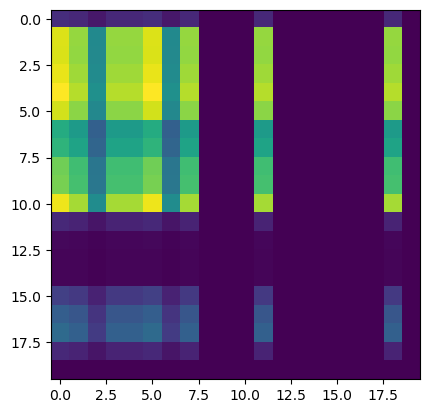

In [6]:
# # there is a topo sort to be applied here ...
# # for row in (all_matrix @ all_matrix)[:-1]:
# #     print('\t'.join(str(s) for s in row[:-1]))
# shuffle(matrices)
# prod_sum = np.eye(N=len(matrices[0]), M=len(matrices[0]))
# for m in matrices:
#     prod_sum = prod_sum @ m
# # for i in range(len(prod_sum)):
# #     for j in range(len(prod_sum)):
# #         if prod_sum[i][j] > 0:
# #             prod_sum[i][j] = 1
# plt.imshow(prod_sum)  # ah- here is a way to cluster the cycles

This represents an edge case where no orthogonal perturbations to state are possible, such as decreasing a concentration of an RNA that does not alter causal network states.

However, usually, this matrix of values shows that in some number of steps, one can get from any cycle to any other cycle; it just might not be the same sequence of perturbations.

#### So, can we put together a sequence of perturbations to get from each cycle to a given cycle, or to each other cycle? (See MOGRIFY)

#### To demonstrate distribution of states, numpy:

In [7]:
import numpy as np


functions = []  #

Another option, but less direct:

#### Adjacency matrix from transitions matrix

By forming an adjacency matrix (with a 1 for each non-zero entry of the transitions matrix, and a 0 otherwise), by raising the matrix to successively higher powers, starting from 1, we can determine whether there exist any sequences of unit perturbations such that the goal states are reachable from all other cycles, in some number of steps (the values of the non-zero entries).

#### For each cycle != goal cycle, cycle states = list[list[state]], make the Cartesian product of each by p1, p2 (unit perturbations),
#### make the Cartesian product of each by a sequence of intervals

Finding a few, not all, is quite quick, but finding all is time-consuming.

In [8]:
from IPython.display import clear_output


# output: list of lists of: (i, goal_cycle_index), p1, p2, min_interval + m)  # =..., interval)
#
def data_condition(data: list[tuple]) -> bool:
    # if last perturbation sequences list has any elements
    pass


#
min_interval = 1
max_interval = 2
# max([len(net.bn_collapsed_cycles.cycle_records[i]) for i in range(len(net.bn_collapsed_cycles.cycle_records))]) // 2
#
i_range = list(range(0, len(net.bn_collapsed_cycles.cycle_records)))
i_range.remove(goal_cycle_index)
#
sequential_perturbations = [
    [] for _ in range(len(net.bn_collapsed_cycles.cycle_records))
]  # expect at least 1 empty list
#
states_labels = dict()
for r in net.list_of_all_run_ins:
    for s in r:
        b = "0b" + "".join([str(int(s[i])) for i in range(len(s))])
        states_labels.update({int(b, base=2): net.bn_collapsed_cycles.get_index(r[-1])})


def select_p1_p2(
    prec_tuples: list,
    base_cycle_states: list,
    seq_perts: list,
    cycle_index: int,
    states_labels: dict,
):
    got_sequence = False
    initial_states = []
    for p1 in set(prec_tuples[i][1] for i in range(len(prec_tuples))):
        for p2 in set(
            prec_tuples[i][2]
            for i in range(len(prec_tuples))
            if prec_tuples[i][1] == p1
        ):
            print(f"\r\t\t\t\tp1: {p1}, p2: {p2}", end="\r")
            for state in base_cycle_states:
                if got_sequence:
                    # break
                    continue
                # apply p1
                p_state = [
                    not (state[k]) if k == p1 else state[k] for k in range(len(state))
                ]
                net.set_conditions(conditions=p_state)  # set net state to state,
                for L in range(min_interval, max_interval + 1):
                    net.advance_state()
                    initial_states.append(copy.deepcopy(net.current_states_list[-1]))
                # apply p2
                # to each of initial (p1) states; run-in from those conditions
                for m in range(len(initial_states)):
                    p1_p2_state = [
                        not (initial_states[m][k]) if k == p2 else initial_states[m][k]
                        for k in range(len(initial_states[m]))
                    ]
                    # net.run_in_from_conditions(p1_p2_state)
                    net.set_conditions(p1_p2_state)
                    while (
                        int(
                            "0b"
                            + "".join(
                                [
                                    str(int(net.current_states_list[-1][i]))
                                    for i in range(len(net.current_states_list[-1]))
                                ]
                            ),
                            base=2,
                        )
                        not in states_labels
                    ):
                        # print('\r... 1')
                        net.advance_state()
                    else:
                        # print('\r..1 1 1 ')
                        cyc_index = states_labels.get(
                            int(
                                "0b"
                                + "".join(
                                    [
                                        str(int(net.current_states_list[-1][i]))
                                        for i in range(len(net.current_states_list[-1]))
                                    ]
                                ),
                                base=2,
                            ),
                            net.bn_collapsed_cycles.get_index(
                                net.current_states_list[-1]
                            ),
                        )
                        for j in range(len(net.current_states_list)):
                            states_labels.update(
                                {
                                    int(
                                        "0b"
                                        + "".join(
                                            [
                                                str(int(net.current_states_list[j][i]))
                                                for i in range(
                                                    len(net.current_states_list[j])
                                                )
                                            ]
                                        ),
                                        base=2,
                                    ): cyc_index
                                }
                            )
                        if (
                            states_labels.get(
                                int(
                                    "0b"
                                    + "".join(
                                        [
                                            str(int(net.current_states_list[-1][i]))
                                            for i in range(
                                                len(net.current_states_list[-1])
                                            )
                                        ]
                                    ),
                                    base=2,
                                )
                            )
                            == goal_cycle_index
                        ):
                            # print(cycle_index)
                            seq_perts[cycle_index].append(
                                (
                                    (cycle_index, goal_cycle_index),
                                    p1,
                                    p2,
                                    (m + 1) % (max_interval - min_interval),
                                )
                            )
                            got_sequence = True

            out_string = ""
            for u in range(len(seq_perts)):
                if u in i_range:
                    out_string += f"\n[{seq_perts[u][:3]}{'...]' if len(seq_perts[u]) > 3 else ']'}"
            clear_output(wait=True)
            print(
                f"\rcycle index: {i}\nsequential perturbations:{out_string}", end="\r"
            )
    return seq_perts


# find the tuples
preceding_tuples = []
for i in range(len(net)):
    for j in range(len(net)):
        preceding_tuples.append((0, i, j))
while len(sequential_perturbations[-1]) == 0:
    shuffle(preceding_tuples)
    sequential_perturbations = select_p1_p2(
        preceding_tuples,
        net.bn_collapsed_cycles.cycle_records[0].cycle_states_list,
        sequential_perturbations,
        i_range[0],
    )
    for i in range(1, len(i_range)):  # _[i] -> cycle index
        shuffle(sequential_perturbations[i - 1])
        sequential_perturbations = select_p1_p2(
            sequential_perturbations[i - 1],
            net.bn_collapsed_cycles.cycle_records[i_range[i]].cycle_states_list,
            sequential_perturbations,
            i_range[i],
        )

for p in sequential_perturbations:
    print(p)

TypeError: select_p1_p2() missing 1 required positional argument: 'states_labels'

In [ ]:
print(len(sequential_perturbations))
for p in sequential_perturbations:
    print(p[:10])